In [197]:
from pyspark.sql import SparkSession
from pathlib import Path
import pyspark.sql.functions as func
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import asc, desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from pyspark.sql.functions import sum as _sum
from pyspark.sql.window import Window
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
from pyspark.sql.functions import lit
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType,NullType


def read_parquet_file(spark, file_path):
    df = spark.read.parquet(file_path)
    return df


def is_hdfs_file_exist(path):
    proc = subprocess.Popen(['hadoop', 'fs', '-test', '-e', path])
    proc.communicate()
    return proc.returncode == 0


def add_index_to_dataframe(df):
    return df.withColumn('index', row_number().over(Window.orderBy(monotonically_increasing_id())))



spark = SparkSession.builder.appName('lr_example').getOrCreate()

# Load data
hdfs_host = "hdfs://localhost:9000"
hdfs_root_path = "/SafeEntry_Analytics/"
case_file_dest = "case_daily_summary.parquet"

all_data = read_parquet_file(spark, hdfs_host+hdfs_root_path+case_file_dest)
all_data.printSchema()



root
 |-- date: string (nullable = true)
 |-- dailyConfirmed: integer (nullable = true)
 |-- falsePositiveFound: integer (nullable = true)
 |-- cumulativeConfirmed: integer (nullable = true)
 |-- dailyDischarged: integer (nullable = true)
 |-- passedButNotDueToCovid: integer (nullable = true)
 |-- cumulativeDischarged: integer (nullable = true)
 |-- dischargedToIsolation: integer (nullable = true)
 |-- stillHospitalized: integer (nullable = true)
 |-- dailyDeaths: integer (nullable = true)
 |-- cumulativeDeaths: integer (nullable = true)
 |-- testedPositiveDemise: integer (nullable = true)
 |-- dailyImported: integer (nullable = true)
 |-- dailyLocalTransmission: integer (nullable = true)
 |-- localCaseResidingInDorms: integer (nullable = true)
 |-- localCaseNotResidingInDorms: integer (nullable = true)
 |-- intensiveCareUnitCases: integer (nullable = true)
 |-- generalWardsMOHReport: integer (nullable = true)
 |-- inIsolationMOHReport: integer (nullable = true)
 |-- totalCompletedIsol

In [168]:
#select key columns and append dayOfWeek & Index column
cases_group_by_date = all_data["date","dailyConfirmed","cumulativeConfirmed",
                               "dailyImported","localCaseNotResidingInDorms","localCaseResidingInDorms"]\
                      .withColumn("dayOfWeek", func.dayofweek(all_data["date"]))\
                      .na.fill(0)
cases_group_by_date = add_index_to_dataframe(cases_group_by_date)
cases_group_by_date.show()
cases_group_by_date.printSchema()

+----------+--------------+-------------------+-------------+---------------------------+------------------------+---------+-----+
|      date|dailyConfirmed|cumulativeConfirmed|dailyImported|localCaseNotResidingInDorms|localCaseResidingInDorms|dayOfWeek|index|
+----------+--------------+-------------------+-------------+---------------------------+------------------------+---------+-----+
|2020-01-23|             1|                  1|            1|                          0|                       0|        5|    1|
|2020-01-24|             2|                  3|            2|                          0|                       0|        6|    2|
|2020-01-25|             1|                  4|            1|                          0|                       0|        7|    3|
|2020-01-26|             0|                  4|            0|                          0|                       0|        1|    4|
|2020-01-27|             1|                  5|            1|                      

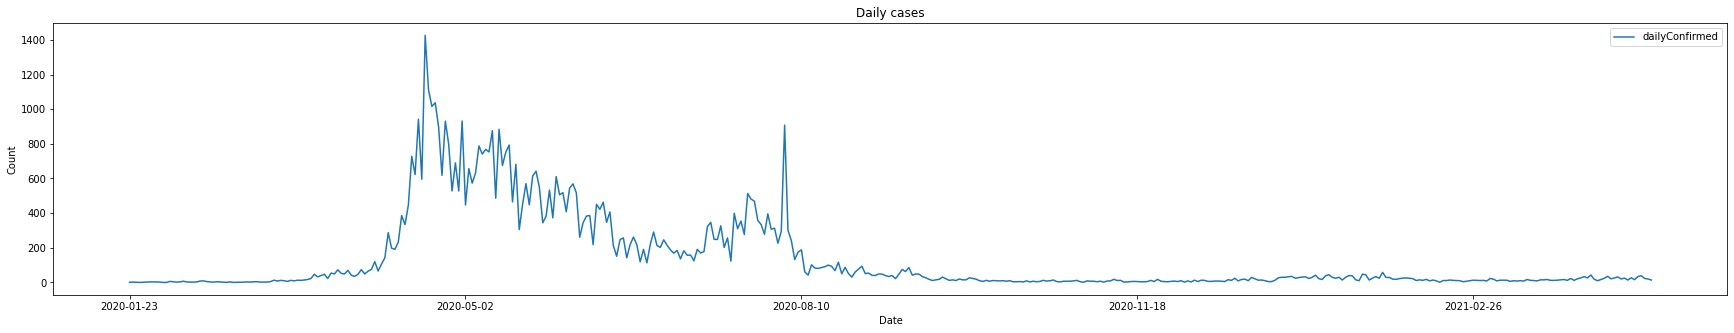

In [169]:
#Show daily confirmed cases linechart
cases_group_by_date.toPandas().plot(x="date", y="dailyConfirmed")
plt.title("Daily cases")
plt.xlabel("Date")
plt.ylabel("Count")
plt.rcParams["figure.figsize"] = (30,5)

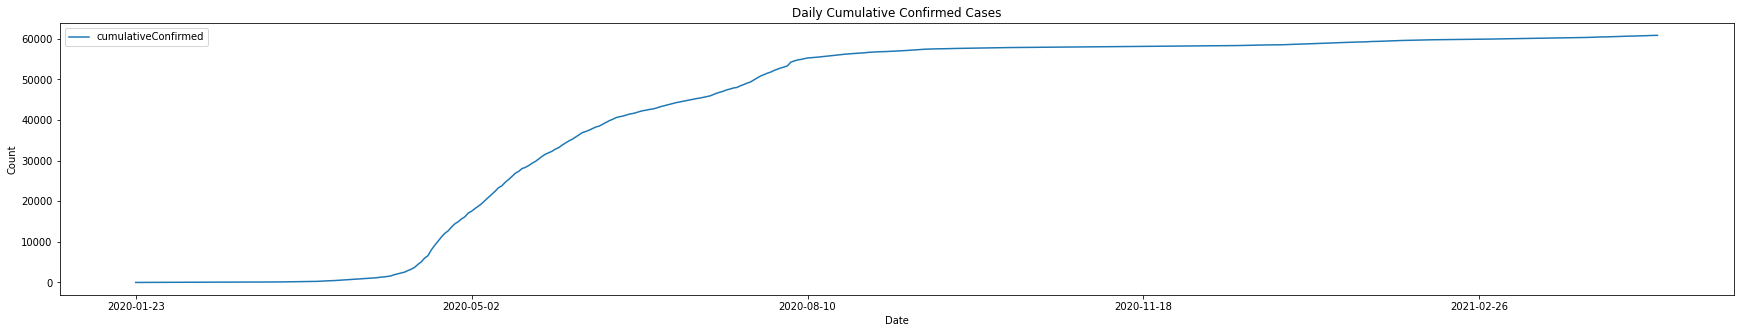

In [170]:
#Show cumulative confirmed cases by day
cases_group_by_date.toPandas().plot(x="date", y="cumulativeConfirmed")
plt.title("Daily Cumulative Confirmed Cases")
plt.xlabel("Date")
plt.ylabel("Count")
plt.rcParams["figure.figsize"] = (30,5)

+---------+-------------------+
|dayOfWeek|sum(dailyConfirmed)|
+---------+-------------------+
|        1|               8866|
|        2|               8128|
|        3|               8157|
|        4|               9574|
|        5|               8735|
|        6|               9212|
|        7|               8273|
+---------+-------------------+



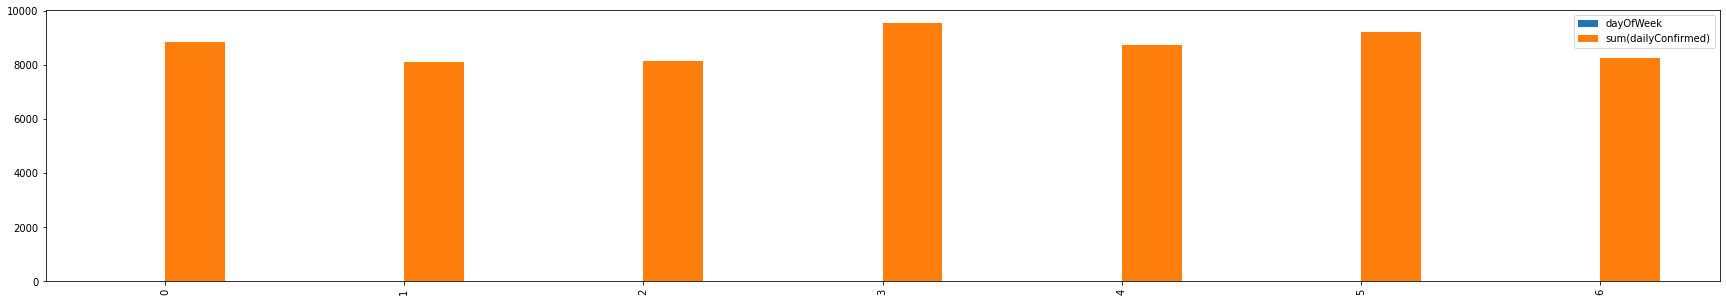

In [171]:
#Show dailyConfirmed cases sum group by dayOfWeek
cases_group_by_day_of_week = cases_group_by_date\
                        .groupby(['dayOfWeek'])\
                        .agg(_sum('dailyConfirmed'))\
                        .orderBy('dayOfWeek',asending=True)
cases_group_by_day_of_week.show()

cases_group_by_day_of_week.toPandas().plot(kind='bar')
plt.rcParams["figure.figsize"] = (5,5)

root
 |-- Case Type: string (nullable = true)
 |-- Count: long (nullable = true)

+------------------------+-----+
|Case Type               |Count|
+------------------------+-----+
|Imported Cases          |3978 |
|Local Transmission Cases|2471 |
|Local Case Reside Dorms |54146|
+------------------------+-----+



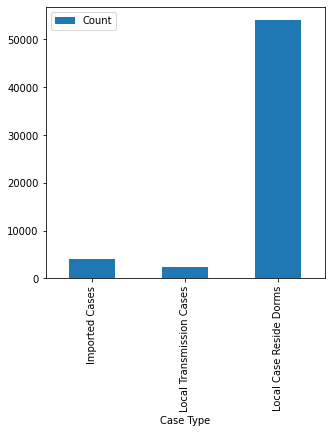

In [172]:
#Show cases group by categories as imported, local cases not residing dorm, local cases residing dorms
case_categories_columns = ["Case Type","Count"]
case_categories = [("Imported Cases",cases_group_by_date.groupBy().sum('dailyImported').collect()[0][0]), 
        ("Local Transmission Cases",cases_group_by_date.groupBy().sum('localCaseNotResidingInDorms').collect()[0][0]), 
        ("Local Case Reside Dorms",cases_group_by_date.groupBy().sum('localCaseResidingInDorms').collect()[0][0])]
case_categories_df = spark.createDataFrame(data=case_categories, schema = case_categories_columns)
case_categories_df.printSchema()
case_categories_df.show(truncate=False)

case_categories_df.toPandas().plot.bar(x="Case Type")
plt.rcParams["figure.figsize"] = (5,5)

In [173]:
#only fetch data after 2020-09-15 for modeling
cases_group_by_date=cases_group_by_date.filter(cases_group_by_date["Date"]>='2020-09-15').drop("index","dailyImported","localCaseNotResidingInDorms","localCaseResidingInDorms")
cases_group_by_date = add_index_to_dataframe(cases_group_by_date)
cases_group_by_date.show()

+----------+--------------+-------------------+---------+-----+
|      date|dailyConfirmed|cumulativeConfirmed|dayOfWeek|index|
+----------+--------------+-------------------+---------+-----+
|2020-09-15|            34|              57488|        3|    1|
|2020-09-16|            27|              57514|        4|    2|
|2020-09-17|            18|              57532|        5|    3|
|2020-09-18|            11|              57543|        6|    4|
|2020-09-19|            15|              57558|        7|    5|
|2020-09-20|            18|              57576|        1|    6|
|2020-09-21|            31|              57606|        2|    7|
|2020-09-22|            21|              57627|        3|    8|
|2020-09-23|            12|              57639|        4|    9|
|2020-09-24|            15|              57654|        5|   10|
|2020-09-25|            11|              57665|        6|   11|
|2020-09-26|            20|              57685|        7|   12|
|2020-09-27|            15|             

In [174]:
# Split into training data and test data
total_count = cases_group_by_date.count()
print(total_count)
seventy_percent_index = round(total_count * 0.7)
cases_group_by_date.registerTempTable("daily_cases")
train_data = spark.sql("select * from daily_cases where index <= {}".format(seventy_percent_index))
test_data = spark.sql("select * from daily_cases where index > {}".format(seventy_percent_index))
train_data.orderBy(desc("index")).show()
test_data.show()

218
+----------+--------------+-------------------+---------+-----+
|      date|dailyConfirmed|cumulativeConfirmed|dayOfWeek|index|
+----------+--------------+-------------------+---------+-----+
|2021-02-14|            14|              59800|        1|  153|
|2021-02-13|             9|              59786|        7|  152|
|2021-02-12|            18|              59777|        6|  151|
|2021-02-11|            12|              59759|        5|  150|
|2021-02-10|            15|              59747|        4|  149|
|2021-02-09|            11|              59732|        3|  148|
|2021-02-08|            22|              59721|        2|  147|
|2021-02-07|            24|              59699|        1|  146|
|2021-02-06|            26|              59675|        7|  145|
|2021-02-05|            25|              59649|        6|  144|
|2021-02-04|            22|              59624|        5|  143|
|2021-02-03|            18|              59602|        4|  142|
|2021-02-02|            19|         

Text(0, 0.5, 'Count')

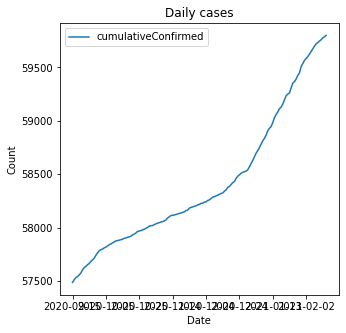

In [175]:
#show train data set in linechart
train_data.toPandas().plot(x="date", y="cumulativeConfirmed")
plt.title("Daily cases")
plt.xlabel("Date")
plt.ylabel("Count")

In [176]:
#did explored https://github.com/sryza/spark-timeseries 
#Autoregressive Integrated Moving Average (ARIMA), not supported by Spark 3.0


# These are the default values for the featuresCol, labelCol, predictionCol
vectorAssembler = VectorAssembler(inputCols=["index"], outputCol="features")
train_sub = vectorAssembler.transform(train_data)
test_sub = vectorAssembler.transform(test_data)

lr = LinearRegression(featuresCol='features',labelCol='cumulativeConfirmed',predictionCol='prediction_cumulativeConfirmed')
# Fit the model
lr_model = lr.fit(train_sub)
# Print the coefficients and intercept training data
print("Coefficients: {}".format(str(lr_model.coefficients)))
print("Intercept: {}".format(str(lr_model.intercept)))

Coefficients: [13.572668301770603]
Intercept: 57369.05486756105


In [177]:
# Testing result
test_result = lr_model.evaluate(test_sub)
test_result.residuals.show()
print("RMSE: {}".format(test_result.rootMeanSquaredError))

+------------------+
|         residuals|
+------------------+
|349.75421396627644|
| 337.1815456645054|
| 334.6088773627416|
| 332.0362090609706|
|332.46354075919953|
| 330.8908724574285|
|328.31820415565744|
| 324.7455358538864|
|315.17286755211535|
| 308.6001992503443|
|305.02753094857326|
| 304.4548626468022|
|302.88219434503117|
| 300.3095260432601|
| 298.7368577414891|
|293.16418943971803|
|  302.591521137947|
|308.01885283617594|
| 303.4461845344049|
|302.87351623263385|
+------------------+
only showing top 20 rows

RMSE: 350.13339798897437


In [178]:
# Prediction
predictions = lr_model.transform(test_sub)

predictions = predictions.withColumn("prediction_cumulativeConfirmed",func.round(predictions["prediction_cumulativeConfirmed"]))

### Defining the window 
Windowspec=Window.orderBy("index")

### Calculating lag of prediction_cumulativeConfirmed at each day level
predictions= predictions.withColumn('prev_day_prediction_cumulativeConfirmed',
                        func.lag(predictions['prediction_cumulativeConfirmed'])
                                .over(Windowspec))

### Calculating prediction_dailyConfirmed                                  
predictions = predictions.withColumn('prediction_dailyConfirmed', 
              predictions['prediction_cumulativeConfirmed'] - predictions['prev_day_prediction_cumulativeConfirmed'])



predictions.show()


+----------+--------------+-------------------+---------+-----+--------+------------------------------+---------------------------------------+-------------------------+
|      date|dailyConfirmed|cumulativeConfirmed|dayOfWeek|index|features|prediction_cumulativeConfirmed|prev_day_prediction_cumulativeConfirmed|prediction_dailyConfirmed|
+----------+--------------+-------------------+---------+-----+--------+------------------------------+---------------------------------------+-------------------------+
|2021-02-15|             9|              59809|        2|  154| [154.0]|                       59459.0|                                   null|                     null|
|2021-02-16|             1|              59810|        3|  155| [155.0]|                       59473.0|                                59459.0|                     14.0|
|2021-02-17|            11|              59821|        4|  156| [156.0]|                       59486.0|                                59473.0|       

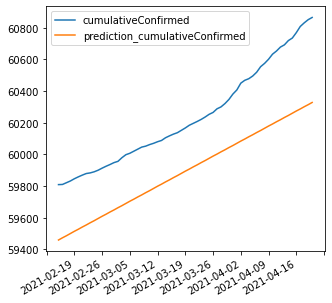

In [187]:
#compare predicted cumulative confirmed vs actual
predictionsPandas = predictions.toPandas()

fig, ax = plt.subplots()

fmt_day = mdates.DayLocator(interval=7)
ax.xaxis.set_major_locator(fmt_day)

plt.plot( 'date', 'cumulativeConfirmed', data=predictionsPandas, marker='')
plt.plot( 'date', 'prediction_cumulativeConfirmed', data=predictionsPandas, marker='')

fig.autofmt_xdate()
# show legend
plt.legend()
# show graph
plt.show()

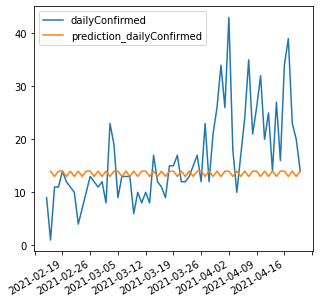

In [201]:
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

#compare predicted dailyConfimred vs actual
predictionsPandas = predictions.toPandas()
fig, ax = plt.subplots()

fmt_day = mdates.DayLocator(interval=7)
ax.xaxis.set_major_locator(fmt_day)

plt.plot( 'date', 'dailyConfirmed', data=predictionsPandas, marker='')
plt.plot( 'date', 'prediction_dailyConfirmed', data=predictionsPandas, marker='')

fig.autofmt_xdate()
# show legend
plt.legend()
# show graph
plt.show()


In [207]:
#predict next x days data
x=30

from datetime import datetime
from datetime import timedelta

test_sub = test_sub.drop("features")
latest_record = test_sub.orderBy(desc("index")).limit(1)
latest_record.show()


lastDate = latest_record.select("date").collect()[0][0]
lastIndex = latest_record.select("index").collect()[0][0]

forcastDataList = []

def addDate(dateStr,dateFormat="%Y-%m-%d", addDays=0):
    datetime_obj = datetime.strptime(dateStr, dateFormat)
    if (addDays!=0):
        anotherTime = datetime_obj + timedelta(days=addDays)
    else:
        anotherTime = datetime_obj
    return anotherTime.strftime(dateFormat)


for i in range(x):
        newDate = lastDate
        date = [addDate(lastDate,"%Y-%m-%d",i+1),0,0,0,lastIndex+i+1]
        forcastDataList.append(date)

        
forcast_df = spark.createDataFrame(forcastDataList)\
            .toDF("date", "dailyConfirmed", "cumulativeConfirmed", "dayOfWeek", "index")
# forcast_df = forcast_df.union(test_sub.drop("features"))
# forcast_df = forcast_df.orderBy(asc("index"))

# These are the default values for the featuresCol, labelCol, predictionCol
vectorAssembler = VectorAssembler(inputCols=["index"], outputCol="features")
forcast_df_sub = vectorAssembler.transform(forcast_df)



# Prediction
forcast_df_sub = lr_model.transform(forcast_df_sub)
forcast_df_sub = forcast_df_sub.withColumn("prediction_cumulativeConfirmed",func.round(forcast_df_sub["prediction_cumulativeConfirmed"]))

### Defining the window 
Windowspec=Window.orderBy("index")

### Calculating lag of prediction_cumulativeConfirmed at each day level
forcast_df_sub= forcast_df_sub.withColumn('prev_day_prediction_cumulativeConfirmed',
                        func.lag(forcast_df_sub['prediction_cumulativeConfirmed'])
                                .over(Windowspec))

### Calculating prediction_dailyConfirmed                                  
forcast_df_sub = forcast_df_sub.withColumn('prediction_dailyConfirmed', 
              forcast_df_sub['prediction_cumulativeConfirmed'] - forcast_df_sub['prev_day_prediction_cumulativeConfirmed'])



forcast_df_sub.orderBy(desc("index")).show()

+----------+--------------+-------------------+---------+-----+
|      date|dailyConfirmed|cumulativeConfirmed|dayOfWeek|index|
+----------+--------------+-------------------+---------+-----+
|2021-04-20|            14|              60865|        3|  218|
+----------+--------------+-------------------+---------+-----+

+----------+--------------+-------------------+---------+-----+--------+------------------------------+---------------------------------------+-------------------------+
|      date|dailyConfirmed|cumulativeConfirmed|dayOfWeek|index|features|prediction_cumulativeConfirmed|prev_day_prediction_cumulativeConfirmed|prediction_dailyConfirmed|
+----------+--------------+-------------------+---------+-----+--------+------------------------------+---------------------------------------+-------------------------+
|2021-05-20|             0|                  0|        0|  248| [248.0]|                       60735.0|                                60722.0|                     13.0|

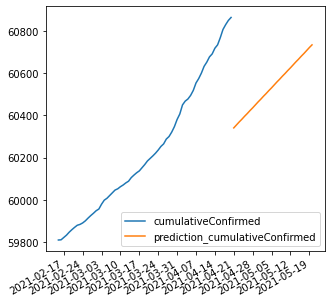

In [208]:
#compare predicted cumulative confirmed vs actual
forcast_pd = forcast_df_sub.toPandas()

fig, ax = plt.subplots()

fmt_day = mdates.DayLocator(interval=7)
ax.xaxis.set_major_locator(fmt_day)

plt.plot( 'date', 'cumulativeConfirmed', data=predictionsPandas, marker='')
plt.plot( 'date', 'prediction_cumulativeConfirmed', data=forcast_pd, marker='')

fig.autofmt_xdate()
# show legend
plt.legend()
# show graph
plt.show()